### University of Washington: Machine Learning and Statistics 

# Lecture 7:  Density Estimation 2

Andrew Connolly and Stephen Portillo

##### Resources for this notebook include:
- [Textbook](https://press.princeton.edu/books/hardcover/9780691198309/statistics-data-mining-and-machine-learning-in-astronomy) Chapter 8. 
- [astroML website](https://www.astroml.org/index.html)

This notebook is developed based on material from A. Connolly, Z. Ivezic, M. Juric, S. Portillo, G. Richards, B. Sipocz, J. VanderPlas, D. Hogg, Killian Weinberger and many others.

The notebook and assoociated material are available from [github](https://github.com/uw-astro/astr-598a-win22).

Make sure you are using the latest version of astroML and pomegranate

> pip install --pre -U astroml

> pip install pomegranate

##### Resources for this notebook include:
- [Textbook](http://press.princeton.edu/titles/10159.html) Chapters 6 and 9.

<a id='toc'></a>

## This notebook includes:
 

[Mixture Models: Gaussian](#gmm)

[How do we choose the number of components](#comp)

[More than just Gaussians](#gmm+)

[Extreme deconvolution (XD)](#xd)

## Mixture Models: Gaussian <a id='gmm'></a>
[Go to top](#toc)


Mixture models use the sum of functions to represent the density distributions - used in defining the density, classifications, cloning of a data set....

Gaussian mixture models (GMMs) are the most common implementation of mixture models

$\rho(\mathbf{x}) = N\, p(\mathbf{x})
  = N\, \sum_{j=1}^M \alpha_j \mathcal{N}(\mu_j, \Sigma_j)$
  

where the model consists of $N$ Gaussians with locations $\mu_j$
and covariances $\Sigma_j$. The log-likelihood is straightforward to define by this model.

<u> _Expectation maximization_ </u> is typically employed to solve for the mixture of Gaussians


- _Expectation_

  - Given a set of Gaussians compute the “expected” classes of all points

- _Maximization_

  - Estimate the MLE of $\mu$, amplitude, and $\Sigma$ given the data’s class membership 

Iterative proceedure until variance does not change. Guaranteed to converge -  monotonically approaches a local minimum of the cost function (but guaranteed to be the correct answer).

In [2]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/Users/ajc/miniconda3/envs/developer/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide


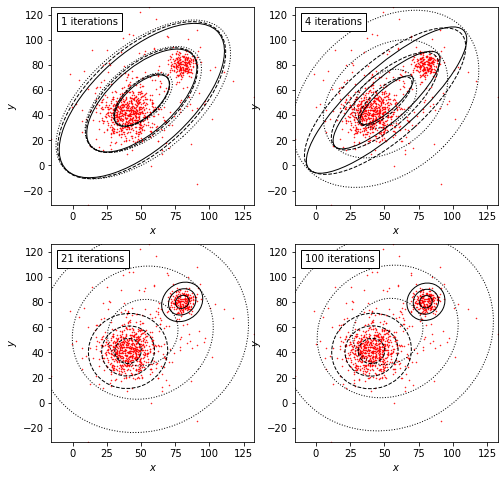

In [3]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from astroML.utils import convert_2D_cov
from astroML.plotting.tools import draw_ellipse

def generate_data(clusters, Npts):
    '''generate data set given set of gaussians'''
    # Set the internal means, covariances, and weights by-hand.
    gmm_input = GaussianMixture(len(clusters), covariance_type='full')
    gmm_input.means_ = np.array([c[0] for c in clusters])
    gmm_input.covariances_ = np.array([convert_2D_cov(*c[1:4]) for c in clusters])
    gmm_input.weights_ = np.array([c[4] for c in clusters])
    gmm_input.weights_ /= gmm_input.weights_.sum()
    gmm_input.precisions_cholesky_ = 1 / np.sqrt(gmm_input.covariances_)
    gmm_input.fit = None
    return gmm_input.sample(Npts)[0]

# define clusters as (mu, sigma1, sigma2, alpha, frac)
Npts=1000
clusters = [((50, 50), 20, 20, 0, 0.1),
        ((40, 40), 10, 10, np.pi / 6, 0.6),
        ((80, 80), 5, 5, np.pi / 3, 0.2),
        ((60, 60), 30, 30, 0, 0.1)]

X = generate_data(clusters, Npts)

#------------------------------------------------------------
# Compute and plot the results
fig = plt.figure(figsize=(8, 8))

def plot_gmm_solution(ax, clf, iterations):  
    ax.plot(X[:, 0], X[:, 1], '.', c='red', ms=1, zorder=1)
    ax.set_xlim(X[:,0].min(), X[:,0].max())
    ax.set_ylim(X[:,1].min(), X[:,1].max())
    ax.set_ylabel('$y$')
    ax.set_xlabel('$x$')
    
    for i in range(clf.n_components):
        mean = clf.means_[i]
        cov = clf.covariances_[i]
        if cov.ndim == 1:
            cov = np.diag(cov)
        draw_ellipse(mean, cov, ax=ax, fc='none', ec='k',ls=linestyles[i], zorder=2)
    
    ax.text(0.05, 0.95, "%i iterations" % iterations,
        ha='left', va='top', transform=ax.transAxes,
        bbox=dict(fc='w', ec='k'))

 
linestyles = ['-', '--', ':']
np.random.seed(1)
#plot solutions as a function of iteration
def fitAndPlot(X, n_components=1, n_iter=100):
    
    for i,iter in enumerate(np.logspace(0, np.log10(n_iter), 4, dtype=int)):
        clf = GaussianMixture(n_components, random_state=np.random.seed(1), 
                              max_iter=iter, init_params='random').fit(X)

        ax = fig.add_subplot(2,2,i+1)
        plot_gmm_solution(ax, clf, iter)
  
fitAndPlot(X, n_components=3, n_iter=100)


## How do we choose the number of components? <a id='comp'></a>
[Go to top](#toc)


Typically used as a density estimation and not as a way of determining the number of Gaussians in a distribution (e.g. imagine what would happen with a single cluster and a uniform background)

Both **Akaike information criterion (AIC)** and **Bayesian information criterion (BIC)** are scoring systems for model comparisons in classical statistics dealing with models with different numbers of free parameters.  

Specifically, **AIC** is computed as

$$AIC \equiv -2 ln(L^0(M)) + 2k + \frac{2k(k+1)}{N-k-1}$$  

**BIC** is computed as

$$BIC \equiv -2ln[L^0(M)] + k lnN$$  
  
AIC, BIC, and cross-validation are often used to define the number of parameters (though this is rarely well defined)

best fit converged: True
n_components =  5


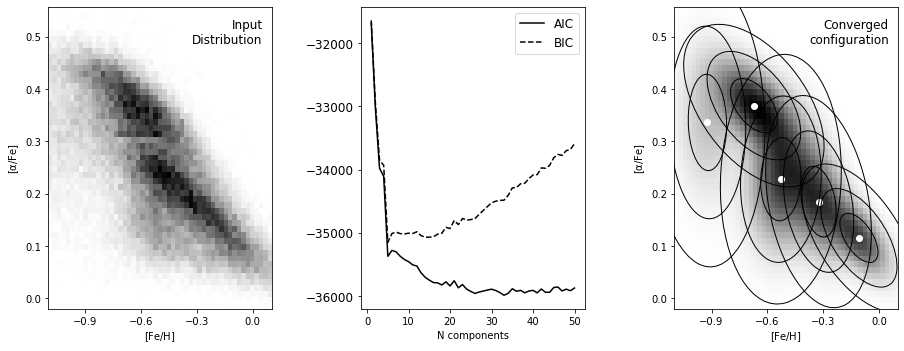

In [3]:
from scipy.stats import norm
from itertools import cycle

from astroML.datasets import fetch_sdss_sspp
from astroML.decorators import pickle_results

#------------------------------------------------------------
# Get the Segue Stellar Parameters Pipeline data
data = fetch_sdss_sspp(cleaned=True)
X = np.vstack([data['FeH'], data['alphFe']]).T

# truncate dataset for speed
X = X[::5]

#------------------------------------------------------------
# Compute GMM models & AIC/BIC
N = np.linspace(1, 50, 50, dtype=int)

def compute_GMM(N, covariance_type='full', n_iter=1000):
    models = [None for n in N]
    for i in range(len(N)):
        models[i] = GaussianMixture(N[i], max_iter=500).fit(X)
    return models

models = compute_GMM(N)

AIC = [m.aic(X) for m in models]
BIC = [m.bic(X) for m in models]

i_best = np.argmin(BIC)
gmm_best = models[i_best]
print ("best fit converged:", gmm_best.converged_)
print ("n_components =  %i" % N[i_best])

#------------------------------------------------------------
# compute 2D density
FeH_bins = 51
alphFe_bins = 51
H, FeH_bins, alphFe_bins = np.histogram2d(data['FeH'], data['alphFe'],
                                          (FeH_bins, alphFe_bins))

Xgrid = np.array(list(map(np.ravel,
                     np.meshgrid(0.5 * (FeH_bins[:-1]
                                        + FeH_bins[1:]),
                                 0.5 * (alphFe_bins[:-1]
                                        + alphFe_bins[1:]))))).T
log_dens = gmm_best.score_samples(Xgrid).reshape((51, 51))

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(19, 6))
fig.subplots_adjust(wspace=0.4,
                    bottom=0.2, top=0.9,
                    left=0.1, right=0.95)

# plot density
ax = fig.add_subplot(141)
ax.imshow(H.T, origin='lower', interpolation='nearest', aspect='auto',
          extent=[FeH_bins[0], FeH_bins[-1],
                  alphFe_bins[0], alphFe_bins[-1]],
          cmap=plt.cm.binary)
ax.set_xlabel(r'$\rm [Fe/H]$')
ax.set_ylabel(r'$\rm [\alpha/Fe]$')
ax.xaxis.set_major_locator(plt.MultipleLocator(0.3))
ax.set_xlim(-1.101, 0.101)
ax.text(0.96, 0.96, "Input\nDistribution", fontsize=12,
        va='top', ha='right', transform=ax.transAxes)

# plot AIC/BIC
ax = fig.add_subplot(142)
ax.plot(N, AIC, '-k', label='AIC')
ax.plot(N, BIC, '--k', label='BIC')
ax.legend(loc=1, prop=dict(size=12))
ax.set_xlabel('N components')
plt.setp(ax.get_yticklabels(), fontsize=12)

# plot best configurations for AIC and BIC
ax = fig.add_subplot(143)
ax.imshow(np.exp(log_dens),
          origin='lower', interpolation='nearest', aspect='auto',
          extent=[FeH_bins[0], FeH_bins[-1],
                  alphFe_bins[0], alphFe_bins[-1]],
          cmap=plt.cm.binary)

linestyles = ['-', '--', ':']
# plot best configurations for AIC and BIC
ax.scatter(gmm_best.means_[:, 0], gmm_best.means_[:, 1], c='w')
for i in range(gmm_best.n_components):
    mean = gmm_best.means_[i]
    cov = gmm_best.covariances_[i]
    if cov.ndim == 1:
        cov = np.diag(cov)
    draw_ellipse(mean, cov, ax=ax, fc='none', ec='k', zorder=2)
    
ax.text(0.96, 0.96, "Converged\nconfiguration", fontsize=12,
        va='top', ha='right', transform=ax.transAxes)

ax.set_xlim(-1.101, 0.101)
ax.set_ylim(alphFe_bins[0], alphFe_bins[-1])
ax.xaxis.set_major_locator(plt.MultipleLocator(0.3))
ax.set_xlabel(r'$\rm [Fe/H]$')
ax.set_ylabel(r'$\rm [\alpha/Fe]$')

plt.show()

#### Variational Bayesian Mixture Models

An interesting approach to choosing Gaussians is Variational Bayesian estimation of a mixture model. Variational methods add regularization by integrating over the prior to calculate the
posterior probability of a data-point belonging to a given cluster given the observed data. We can then shrink the number of components if low weight. In scikit-learn this is BayesianGaussianMixture


Text(0, 0.5, '$\\rm [\\alpha/Fe]$')

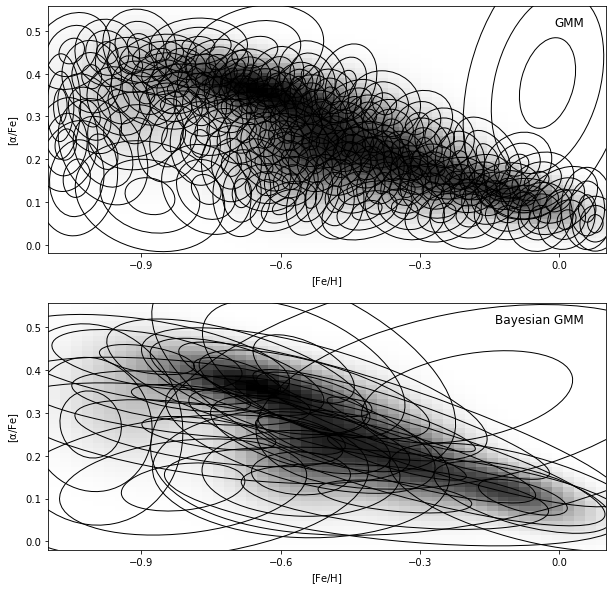

In [4]:
#------------------------------------------------------------
# Get the Segue Stellar Parameters Pipeline data
data = fetch_sdss_sspp(cleaned=True)
X = np.vstack([data['FeH'], data['alphFe']]).T

# truncate dataset for speed
X = X[::5]

#------------------------------------------------------------
# Compute GMM models & AIC/BIC

#start with a ridicoulous number
N=100
modelGMM = GaussianMixture(N, max_iter=500).fit(X)

modelBGMM = BayesianGaussianMixture(n_components=N, max_iter=500).fit(X)

fig = plt.figure(figsize=(10, 10))

#GMM approach
ax = fig.add_subplot(211)
ax.imshow(np.exp(log_dens),
          origin='lower', interpolation='nearest', aspect='auto',
          extent=[FeH_bins[0], FeH_bins[-1],
                  alphFe_bins[0], alphFe_bins[-1]],
          cmap=plt.cm.binary)

for i in range(modelGMM.n_components):
    mean = modelGMM.means_[i]
    cov = modelGMM.covariances_[i]
    if cov.ndim == 1:
        cov = np.diag(cov)
    draw_ellipse(mean, cov, ax=ax, fc='none', ec='k', zorder=2)

ax.text(0.96, 0.96, "GMM", fontsize=12,
        va='top', ha='right', transform=ax.transAxes)

ax.set_xlim(-1.101, 0.101)
ax.set_ylim(alphFe_bins[0], alphFe_bins[-1])
ax.xaxis.set_major_locator(plt.MultipleLocator(0.3))
ax.set_xlabel(r'$\rm [Fe/H]$')
ax.set_ylabel(r'$\rm [\alpha/Fe]$')


#BGMM approach
pred = modelBGMM.predict(X)

ax = fig.add_subplot(212)
ax.imshow(np.exp(log_dens),
          origin='lower', interpolation='nearest', aspect='auto',
          extent=[FeH_bins[0], FeH_bins[-1],
                  alphFe_bins[0], alphFe_bins[-1]],
          cmap=plt.cm.binary)

for i in range(modelBGMM.n_components):
    mean = modelBGMM.means_[i]
    cov = modelBGMM.covariances_[i]
    # remove component if no data points contribute to it
    if not np.any(pred == i):
            continue
    if cov.ndim == 1:
        cov = np.diag(cov)
    draw_ellipse(mean, cov, ax=ax, fc='none', ec='k', zorder=2)
    
ax.text(0.96, 0.96, "Bayesian GMM", fontsize=12,
        va='top', ha='right', transform=ax.transAxes)

ax.set_xlim(-1.101, 0.101)
ax.set_ylim(alphFe_bins[0], alphFe_bins[-1])
ax.xaxis.set_major_locator(plt.MultipleLocator(0.3))
ax.set_xlabel(r'$\rm [Fe/H]$')
ax.set_ylabel(r'$\rm [\alpha/Fe]$')


#### Exercise: clustering of orbital data for asteroids

Asteroids are clustered in orbital parameter space (6 dimensions
but here we will consider two: semi-major axis and inclination)
and these clusters, known as families, are believed to be remnants of larger asteroids destroyed in collisions. Typically, families have
uniform colors, for more details see [Parker et al. 2008.](
http://faculty.washington.edu/ivezic/Publications/parker.pdf)

Using the Parker et al. dataset, available from astroML, apply 
a Gaussian Mixture Model and estimate the number of components

Text(0, 0.5, 'sin(i)')

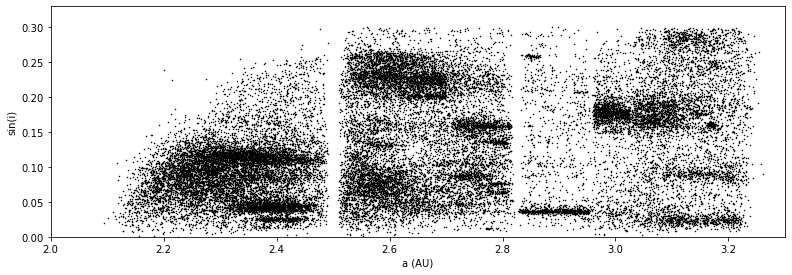

In [20]:
# Fetch data and extract the desired quantities
from astroML.datasets import fetch_moving_objects
dataAll = fetch_moving_objects(Parker2008_cuts=True)
data = dataAll[1:]
a = data['aprime']
sini = data['sin_iprime']
acolor = data['mag_a']
izcolor = data['mag_i'] - data['mag_z']
X = np.vstack([a, sini]).T

#------------------------------------------------------------
# Plot 
xmin, xmax = (2.0, 3.3)
ymin, ymax = (0.0, 0.33)
fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(hspace=0, left=0.1, right=0.95, bottom=0.1, top=0.9)

ax = fig.add_subplot(311)
ax.scatter(X[:, 0], X[:, 1], s=1, lw=0.5, c='k')
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_xlabel('a (AU)')
ax.set_ylabel('sin(i)')


## More than just Gaussians <a id='gmm+'></a>
[Go to top](#toc)

We can extend GMM to more than Gaussians with packages such as [Pomegranate](https://pomegranate.readthedocs.io/en/latest/index.html) including UniformDistributions

Compare a distribution with a background


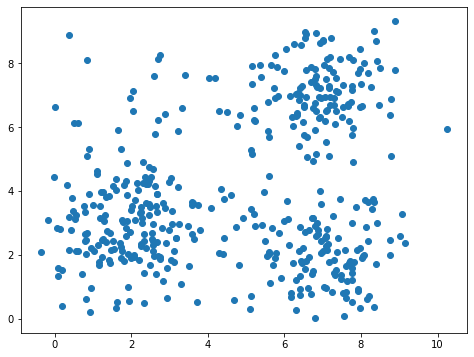

In [4]:
from pomegranate import *

# 3 Gaussians and a uniform background
X = np.concatenate([np.random.normal((7, 2), 1, size=(100, 2)),
                       np.random.normal((2, 3), 1, size=(150, 2)),
                       np.random.normal((7, 7), 1, size=(100, 2)), 
                       np.random.uniform(low=0.0, high=9.0, size=(100, 2))])

X_test = np.concatenate([np.random.normal((7, 2), 1, size=(100, 2)),
                       np.random.normal((2, 3), 1, size=(150, 2)),
                       np.random.normal((7, 7), 1, size=(100, 2)), 
                       np.random.uniform(low=0.0, high=9.0, size=(100, 2))])

plt.figure(figsize=(8, 6))
plt.scatter(X[:,0], X[:,1])
plt.show()


0.28


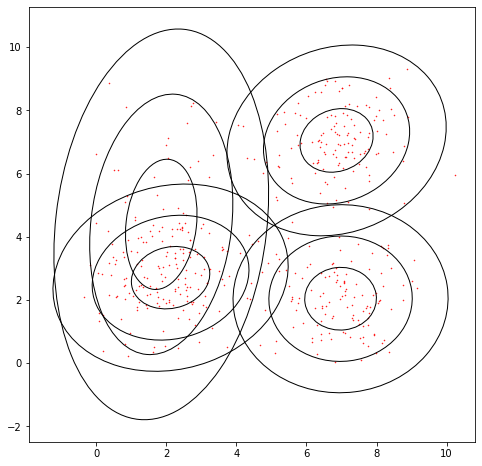

In [5]:
#fit 4 Gaussians
model = GeneralMixtureModel.from_samples(MultivariateGaussianDistribution, 4, X)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.plot(X[:, 0], X[:, 1], '.', c='red', ms=1, zorder=1)
for i in range(len(model.distributions)):
    mean = model.distributions[i].parameters[0]
    cc = np.array(model.distributions[i].parameters[1])
    draw_ellipse(mean, cc, ax=ax, fc='none', ec='k', zorder=2)
    continue
print(model.score(X_test,np.ones(len(X))))

0.24888888888888888


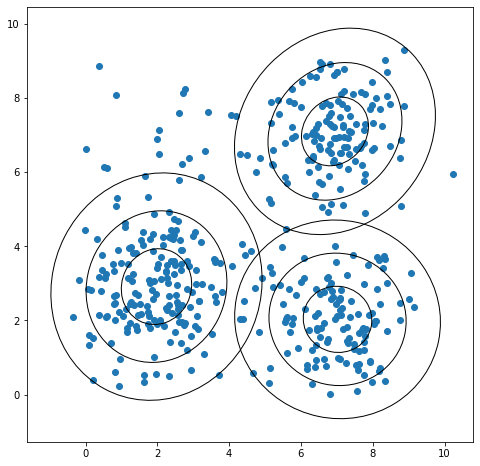

In [13]:
# fit 3 Gaussians and a uniform background
d1 = MultivariateGaussianDistribution([1, 6], [[1, 0], [0, 1]])
d2 = MultivariateGaussianDistribution([2, 8], [[1, 0], [0, 1]])
d3 = MultivariateGaussianDistribution([1, 4], [[1, 0], [0, 1]])
d4 = IndependentComponentsDistribution([UniformDistribution(0,9), UniformDistribution(0,9)])
model = GeneralMixtureModel([d1, d2, d3, d4])
model.fit(X)

fig = plt.figure(figsize=(8, 8))
ax = plt.subplot(111)
plt.scatter(X[:,0], X[:,1])

for i in range(len(model.distributions)):
    if model.distributions[i].name != 'IndependentComponentsDistribution':
        mean = model.distributions[i].parameters[0]
        cc = np.array(model.distributions[i].parameters[1])
        draw_ellipse(mean, cc, ax=ax, fc='none', ec='k', zorder=2)
print(model.score(X_test,np.ones(len(X))))

## Extreme deconvolution (XD) <a id='xd'></a>
[Go to top](#toc)


Combines Baysian estimation and Gaussian models to correct data with measurement errors. The algorithm basically assumes an observed (noisy) value ${x_i}$, true value ${v_i}$, and noise ${\epsilon}$ 
have the following relationship:

$${x_i} = {R_i}{v_i}+{\epsilon_i}$$  

where ${R_i}$ is a projection matrix (which may or may not be invertible) and we assume the $\epsilon_i$ is has a zero mean and variance $S_i$ 

We want a mixture of Gaussians for the true values which represents our model. Given the observed values and noise we can calculate the likelihood of this model (this is a mixture of Gaussians) which we can optimize.  

We use expectation maximization to accomplish this. $q_{ij}$ are the labels for point $i$ and Gaussian $j$. The conditional distribution of  $v_i$ given   $x_i$ has a Gaussian with mean $b_{ij}$ and variance $B_{ij}$. 

The expectation step becomes:

$$
\begin{eqnarray}
q_{ij}&\leftarrow & \frac{\alpha_j\mathcal{N}(\mathbf{x}_i|\mathbf{R}_i\mathbf{\mu}_j,\mathbf{T}_{ij})}{\sum_k
  \alpha_k \mathcal{N}(\mathbf{x}_i|\mathbf{R}_i\mathbf{\mu}_k,\mathbf{T}_{ij})},\\
  \mathbf{b}_{ij}&\leftarrow & \mathbf{\mu}_j +
  \mathbf{\Sigma}_j\mathbf{R}_i^T\mathbf{T}_{ij}^{-1}(\mathbf{x
  }_i-\mathbf{R}_i\mathbf{\mu}_j),\\
  \mathbf{B}_{ij}&\leftarrow &\mathbf{\Sigma}_j-\mathbf{\Sigma}_j\mathbf{R}_i^T\mathbf{T}_{ij}^{-1}\mathbf{R}_i\mathbf{\Sigma}_j,
\end{eqnarray}
$$

with
$\mathbf{T}_{ij} = \mathbf{R}_i\mathbf{\Sigma}_j\mathbf{R}_i^T + \mathbf{S}_i$.

The maximization step becomes:

$$
\begin{eqnarray}
  \alpha_i&\leftarrow & \frac{1}{N}\sum_i q_{ij},\\
  \mathbf{\mu}_j &\leftarrow & \frac{1}{q_j}\sum_i
  q_{ij}\mathbf{b}_{ij},\\
  \mathbf{\Sigma}_j&\leftarrow &\frac{1}{q_j}\sum_i
  q_{ij}[(\mathbf{\mu}_j-\mathbf{b}_{ij})(\mathbf{\mu}_j-\mathbf{b}_{ij}^T)+\mathbf{B}_{ij}],
\end{eqnarray}
$$

with $q_j = \sum_i q_{ij}$.

#### XD: Simulated data

We first generate a distribution of "true data" using radomized numbers. We will plot this data set as a reference to compare with the model derived from estimation with XD.

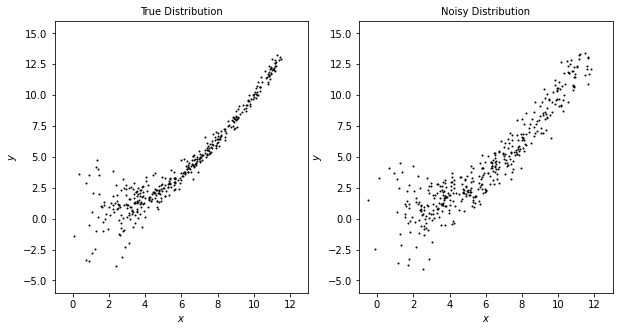

In [20]:
# Sample the dataset. 
# Here we use sample size = 400 in the example, 
# which converges in shorter time, and gives reasonable result.
N = 400
np.random.seed(0)

# generate the true data
x_true = (1.4 + 2 * np.random.random(N)) ** 2
y_true = 0.1 * x_true ** 2

# add scatter to "true" distribution
dx = 0.1 + 4. / x_true ** 2
dy = 0.1 + 10. / x_true ** 2

x_true += np.random.normal(0, dx, N)
y_true += np.random.normal(0, dy, N)

# add noise to get the "observed" distribution
dx = 0.2 + 0.5 * np.random.random(N)
dy = 0.2 + 0.5 * np.random.random(N)

x = x_true + np.random.normal(0, dx)
y = y_true + np.random.normal(0, dy)


# define a function to plot all distributions in the same format
def plot_distribution(ax, text, sample_x, sample_y):
    ax.scatter(sample_x, sample_y, s=4,lw=0,c='k')
    ax.set_xlim(-1, 13)
    ax.set_ylim(-6, 16)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_title(text,fontsize=10)


fig = plt.figure(figsize=(10, 5))
# plot true distribution
ax = fig.add_subplot(121)
plot_distribution(ax, 'True Distribution', x_true, y_true)
# plot noisy distribution
ax = fig.add_subplot(122)
plot_distribution(ax, 'Noisy Distribution', x, y)


plt.show()

#### Compute extreme deconvolution (XD)
In the XDGMM method, n_components (integer) defines the number of Gaussian components to fit to the data. max_iter (integer) defines number of EM iterations to perform (default as 100). Larger iteration number generally contributes better approximation to the true data, but takes longer time to execute. 

In [21]:
from astroML.density_estimation import XDGMM

# stack the results for computation
X = np.vstack([x, y]).T
Xerr = np.zeros(X.shape + X.shape[-1:])
diag = np.arange(X.shape[-1])
Xerr[:, diag, diag] = np.vstack([dx ** 2, dy ** 2]).T

clf = XDGMM(n_components=10, max_iter=200)

clf.fit(X, Xerr)
sample = clf.sample(N)

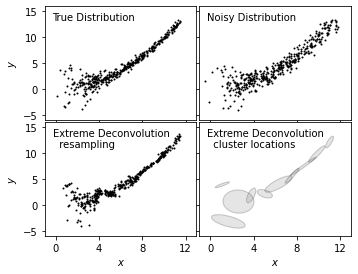

In [22]:
# Plot the results
fig = plt.figure(figsize=(5, 3.75))
fig.subplots_adjust(left=0.1, right=0.95,
                    bottom=0.1, top=0.95,
                    wspace=0.02, hspace=0.02)

ax1 = fig.add_subplot(221)
ax1.scatter(x_true, y_true, s=4, lw=0, c='k')

ax2 = fig.add_subplot(222)
ax2.scatter(x, y, s=4, lw=0, c='k')

ax3 = fig.add_subplot(223)
ax3.scatter(sample[:, 0], sample[:, 1], s=4, lw=0, c='k')

ax4 = fig.add_subplot(224)
for i in range(clf.n_components):
    draw_ellipse(clf.mu[i], clf.V[i], scales=[2], ax=ax4,
                 ec='k', fc='gray', alpha=0.2)

titles = ["True Distribution", "Noisy Distribution",
          "Extreme Deconvolution\n  resampling",
          "Extreme Deconvolution\n  cluster locations"]

ax = [ax1, ax2, ax3, ax4]

for i in range(4):
    ax[i].set_xlim(-1, 13)
    ax[i].set_ylim(-6, 16)

    ax[i].xaxis.set_major_locator(plt.MultipleLocator(4))
    ax[i].yaxis.set_major_locator(plt.MultipleLocator(5))

    ax[i].text(0.05, 0.95, titles[i],
               ha='left', va='top', transform=ax[i].transAxes)

    if i in (0, 1):
        ax[i].xaxis.set_major_formatter(plt.NullFormatter())
    else:
        ax[i].set_xlabel('$x$')

    if i in (1, 3):
        ax[i].yaxis.set_major_formatter(plt.NullFormatter())
    else:
        ax[i].set_ylabel('$y$')

#### XD on real star sample
We use a set of standard stars from Stripe 82 (high SNR), and a set of noisy single epoch of stars (low SNR). We will perform XD on the noisy data and see how it resamples the data into clusters.

First, we fix the star's true color from dust extinction in noisy data sample. We apply extinction correction curve defined as 
$C_{\lambda} \equiv \frac{A_{\lambda}}{A}$, where the value of $C_{\lambda}$ for each band of S82 is from [Berry et al 2012](https://ui.adsabs.harvard.edu/abs/2012ApJ...757..166B/abstract).

In [23]:
from astroML.datasets import fetch_sdss_S82standards, fetch_imaging_sample

# define u-g-r-i-z extinction from Berry et al, arXiv 1111.4985 multiply extinction by A_r
extinction_vector = np.array([1.810, 1.400, 1.0, 0.759, 0.561])

# Fetch and process the noisy imaging data
data_noisy = fetch_imaging_sample()

# select only stars
data_noisy = data_noisy[data_noisy['type'] == 6]

# Get the extinction-corrected magnitudes for each band
X = np.vstack([data_noisy[f + 'RawPSF'] for f in 'ugriz']).T
Xerr = np.vstack([data_noisy[f + 'psfErr'] for f in 'ugriz']).T

# extinction terms from Berry et al, arXiv 1111.4985
X -= (extinction_vector * data_noisy['rExtSFD'][:, None])

Next, we stack the S82 star set and perform the same extinction correction on the data. 

In [24]:
# Fetch and process the stacked imaging data
data_stacked = fetch_sdss_S82standards()

# cut to RA, DEC range of imaging sample
RA = data_stacked['RA']
DEC = data_stacked['DEC']
data_stacked = data_stacked[(RA > 0) & (RA < 10) &
                            (DEC > -1) & (DEC < 1)]

# get stacked magnitudes for each band
Y = np.vstack([data_stacked['mmu_' + f] for f in 'ugriz']).T
Yerr = np.vstack([data_stacked['msig_' + f] for f in 'ugriz']).T

# extinction terms from Berry et al, arXiv 1111.4985
Y -= (extinction_vector * data_stacked['A_r'][:, None])

# quality cuts
g = Y[:, 1]
mask = ((Yerr.max(1) < 0.05) &
        (g < 20))
data_stacked = data_stacked[mask]
Y = Y[mask]
Yerr = Yerr[mask]

#### Cross-match two data sets
We use astroML's crossmatch to match the noisy sample to standard sample, and make two sets comparable.

In [25]:
from astroML.crossmatch import crossmatch

Xlocs = np.hstack((data_noisy['ra'][:, np.newaxis],
                   data_noisy['dec'][:, np.newaxis]))
Ylocs = np.hstack((data_stacked['RA'][:, np.newaxis],
                   data_stacked['DEC'][:, np.newaxis]))

print("number of noisy points:  ", Xlocs.shape)
print("number of stacked points:", Ylocs.shape)

# find all points within 0.9 arcsec.  This cutoff was selected
# by plotting a histogram of the log(distances).
dist, ind = crossmatch(Xlocs, Ylocs, max_distance=0.9 / 3600)

noisy_mask = (~np.isinf(dist))
stacked_mask = ind[noisy_mask]

# select the data
data_noisy = data_noisy[noisy_mask]
X = X[noisy_mask]
Xerr = Xerr[noisy_mask]

data_stacked = data_stacked[stacked_mask]
Y = Y[stacked_mask]
Yerr = Yerr[stacked_mask]

# double-check that our cross-match succeeded
assert X.shape == Y.shape
print("size after crossmatch:", X.shape)

number of noisy points:   (82003, 2)
number of stacked points: (13377, 2)
size after crossmatch: (12313, 5)


In [26]:
# first define mixing matrix W
W = np.array([[0, 1, 0, 0, 0],    # g magnitude
              [1, -1, 0, 0, 0],   # u-g color
              [0, 1, -1, 0, 0],   # g-r color
              [0, 0, 1, -1, 0],   # r-i color
              [0, 0, 0, 1, -1]])  # i-z color

X = np.dot(X, W.T)
Y = np.dot(Y, W.T)

# compute error covariance from mixing matrix
Xcov = np.zeros(Xerr.shape + Xerr.shape[-1:])
Xcov[:, range(Xerr.shape[1]), range(Xerr.shape[1])] = Xerr ** 2

# each covariance C = WCW^T
# best way to do this is with a tensor dot-product
Xcov = np.tensordot(np.dot(Xcov, W.T), W, (-2, -1))

We choose ten percent of the points in each data sets to plot in comparison. As we can see from the result, before XD, the sigle epoch (right) has more noise than standard stars (left).

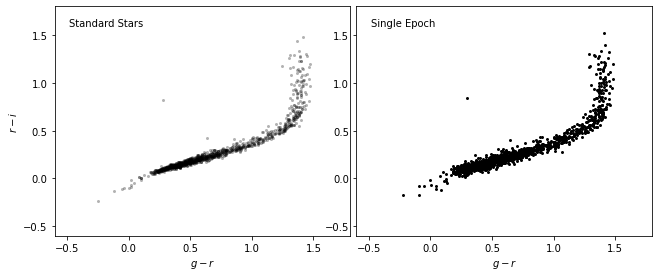

In [27]:
# Fit and sample from the underlying distribution
np.random.seed(42)
X_sample = clf.sample(X.shape[0])

# plot the results
fig = plt.figure(figsize=(10, 3.75))
fig.subplots_adjust(left=0.12, right=0.95,
                    bottom=0.1, top=0.95,
                    wspace=0.02, hspace=0.02)

# only plot 1/10 of the stars for clarity
ax1 = fig.add_subplot(121)
ax1.scatter(Y[::10, 2], Y[::10, 3], s=9, lw=0, alpha=0.3, c='k')
ax1.set_ylabel('$r-i$')

ax2 = fig.add_subplot(122)
ax2.scatter(X[::10, 2], X[::10, 3], s=9, lw=0, c='k')

titles = ["Standard Stars", "Single Epoch"]
ax = [ax1, ax2]

for i in range(2):
    ax[i].set_xlim(-0.6, 1.8)
    ax[i].set_ylim(-0.6, 1.8)

    ax[i].xaxis.set_major_locator(plt.MultipleLocator(0.5))
    ax[i].yaxis.set_major_locator(plt.MultipleLocator(0.5))

    ax[i].text(0.05, 0.95, titles[i],
               ha='left', va='top', transform=ax[i].transAxes)

    ax[i].set_xlabel('$g-r$')

#### Calculate XD 
We define compute_XD and save the result to pickle file. This cell is estimated to take a long running time (more than 20 minutes).

In [28]:
def compute_XD(n_clusters=12, rseed=0, max_iter=20, verbose=True):
    np.random.seed(rseed)
    clf = XDGMM(n_clusters, max_iter=max_iter, tol=1E-5, verbose=verbose)
    clf.fit(X, Xcov)
    return clf

clf = compute_XD(12)

1: log(L) = 32868
    (6.7 sec)
2: log(L) = 33422
    (6.6 sec)
3: log(L) = 33742
    (6.5 sec)
4: log(L) = 33967
    (6.6 sec)
5: log(L) = 34155
    (6.6 sec)
6: log(L) = 34307
    (6.6 sec)
7: log(L) = 34418
    (6.6 sec)
8: log(L) = 34507
    (6.7 sec)
9: log(L) = 34583
    (6.8 sec)
10: log(L) = 34648
    (6.6 sec)
11: log(L) = 34707
    (6.5 sec)
12: log(L) = 34762
    (6.5 sec)
13: log(L) = 34818
    (6.4 sec)
14: log(L) = 34884
    (6.4 sec)
15: log(L) = 34943
    (6.4 sec)
16: log(L) = 34988
    (6.4 sec)
17: log(L) = 35028
    (6.4 sec)
18: log(L) = 35066
    (6.4 sec)
19: log(L) = 35103
    (6.4 sec)
20: log(L) = 35138
    (6.4 sec)


#### Compare the deconvolved colors and the stacked data
We plot the result of noisy data after XD in scattered points (lower left), with a cluster location estimation in ellipses, in comparison with the original two data sets.   After XD resampling, the resampled data distributes less scattered than the original noisy data. It also shows a better clustered pattern than the standard star distribution.

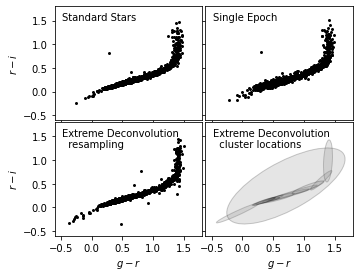

In [29]:
# Fit and sample from the underlying distribution
np.random.seed(42)
X_sample = clf.sample(X.shape[0])

# plot the results
fig = plt.figure(figsize=(5, 3.75))
fig.subplots_adjust(left=0.12, right=0.95,
                    bottom=0.1, top=0.95,
                    wspace=0.02, hspace=0.02)

# only plot 1/10 of the stars for clarity
ax1 = fig.add_subplot(221)
ax1.scatter(Y[::10, 2], Y[::10, 3], s=9, lw=0, c='k')

ax2 = fig.add_subplot(222)
ax2.scatter(X[::10, 2], X[::10, 3], s=9, lw=0, c='k')

ax3 = fig.add_subplot(223)
ax3.scatter(X_sample[::10, 2], X_sample[::10, 3], s=9, lw=0, c='k')

ax4 = fig.add_subplot(224)
for i in range(clf.n_components):
    draw_ellipse(clf.mu[i, 2:4], clf.V[i, 2:4, 2:4], scales=[2],
                 ec='k', fc='gray', alpha=0.2, ax=ax4)

titles = ["Standard Stars", "Single Epoch",
          "Extreme Deconvolution\n  resampling",
          "Extreme Deconvolution\n  cluster locations"]
ax = [ax1, ax2, ax3, ax4]

for i in range(4):
    ax[i].set_xlim(-0.6, 1.8)
    ax[i].set_ylim(-0.6, 1.8)

    ax[i].xaxis.set_major_locator(plt.MultipleLocator(0.5))
    ax[i].yaxis.set_major_locator(plt.MultipleLocator(0.5))

    ax[i].text(0.05, 0.95, titles[i],
               ha='left', va='top', transform=ax[i].transAxes)

    if i in (0, 1):
        ax[i].xaxis.set_major_formatter(plt.NullFormatter())
    else:
        ax[i].set_xlabel('$g-r$')

    if i in (1, 3):
        ax[i].yaxis.set_major_formatter(plt.NullFormatter())
    else:
        ax[i].set_ylabel('$r-i$')

#### Width of the stellar locus
We plot the widths of standard stars, single epoch and XD resampled result in one graph. On the x-axis shows the width of locus, also called w color, defined as 
$w = -0.227g + 0.792r - 0.567i + 0.05$.   $\sigma_{G}$ of the Gaussian distribution fit is the smallest in XD resampled result.

Text(0, 0.5, '$N(w)$')

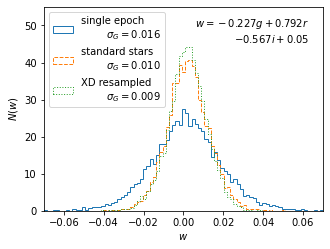

In [30]:
from astroML.stats import sigmaG

# Second figure: the width of the locus
fig = plt.figure(figsize=(5, 3.75))
ax = fig.add_subplot(111)

labels = ['single epoch', 'standard stars', 'XD resampled']
linestyles = ['solid', 'dashed', 'dotted']
for data, label, ls in zip((X, Y, X_sample), labels, linestyles):
    g = data[:, 0]
    gr = data[:, 2]
    ri = data[:, 3]

    r = g - gr
    i = r - ri

    mask = (gr > 0.3) & (gr < 1.0)
    g = g[mask]
    r = r[mask]
    i = i[mask]

    w = -0.227 * g + 0.792 * r - 0.567 * i + 0.05

    sigma = sigmaG(w)

    ax.hist(w, bins=np.linspace(-0.08, 0.08, 100), linestyle=ls,
            histtype='step', label=label + '\n\t' + r'$\sigma_G=%.3f$' % sigma,
            density=True)

ax.legend(loc=2)
ax.text(0.95, 0.95, '$w = -0.227g + 0.792r$\n$ - 0.567i + 0.05$',
        transform=ax.transAxes, ha='right', va='top')

ax.set_xlim(-0.07, 0.07)
ax.set_ylim(0, 55)

ax.set_xlabel('$w$')
ax.set_ylabel('$N(w)$')